UTS Model Deployment (Dataset A)

2702221135 - Octavius Sandriago

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import xgboost as xgb
import pickle

In [2]:
df = pd.read_csv('Dataset_A_loan.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


# A

## Find Anomalies

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   42750 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

__EXPLANATION__ : There is no wrong format in each column

In [4]:
df.isna().sum()

person_age                           0
person_gender                        0
person_education                     0
person_income                     2250
person_emp_exp                       0
person_home_ownership                0
loan_amnt                            0
loan_intent                          0
loan_int_rate                        0
loan_percent_income                  0
cb_person_cred_hist_length           0
credit_score                         0
previous_loan_defaults_on_file       0
loan_status                          0
dtype: int64

In [5]:
df['person_income'].isna().sum() / len(df) * 100

np.float64(5.0)

__EXPLANATION__ : person_income column has 2250 missing values or 5% of its value is missing, because it is quite small percentage of data (<10%) we can impute it

## Handling Anomalies

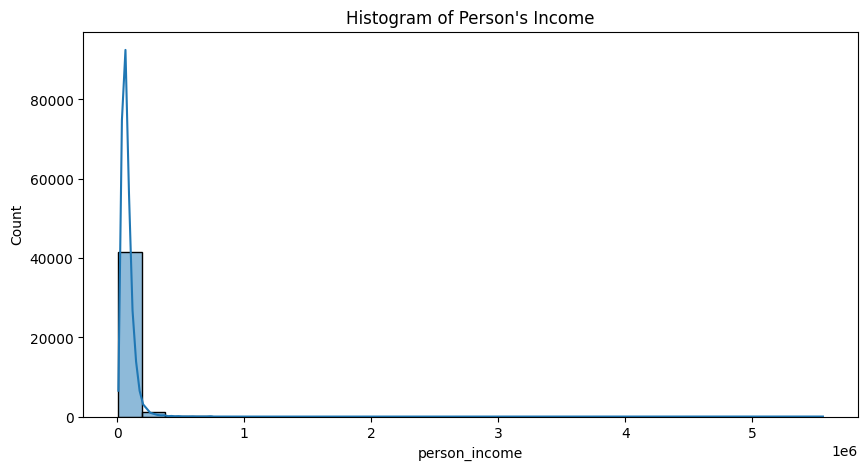

In [6]:
plt.figure(figsize=(10,5))
sns.histplot(df['person_income'], bins=30, kde=True)
plt.title(f'Histogram of Person\'s Income')

plt.show()

__EXPLANATION__ : Plot the distribution of person_income, and can be seen it is not normally distributed,  meaning we impute it with its median

In [7]:
df['person_income'] = df['person_income'].fillna(df['person_income'].median())
df.isna().sum()

person_age                        0
person_gender                     0
person_education                  0
person_income                     0
person_emp_exp                    0
person_home_ownership             0
loan_amnt                         0
loan_intent                       0
loan_int_rate                     0
loan_percent_income               0
cb_person_cred_hist_length        0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
dtype: int64

In [8]:
categorical = []
numerical = []

for i in df.columns:
    if 'int' in str(df[i].dtype) or 'float' in str(df[i].dtype):
        numerical.append(i)
    else:
        categorical.append(i)

print(f'Categorical: {categorical}')
print(f'Numeric: {numerical}')

Categorical: ['person_gender', 'person_education', 'person_home_ownership', 'loan_intent', 'previous_loan_defaults_on_file']
Numeric: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score', 'loan_status']


## EDA

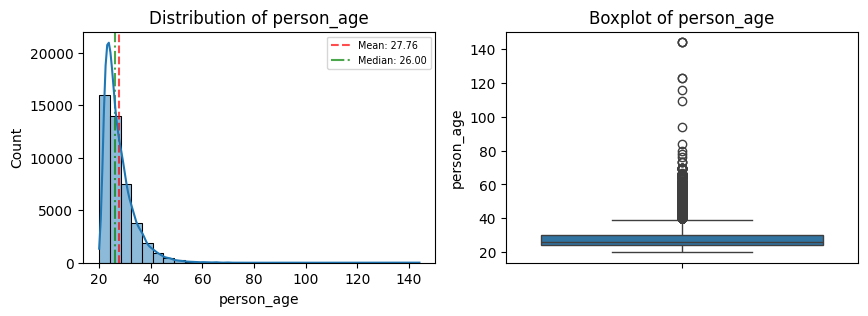

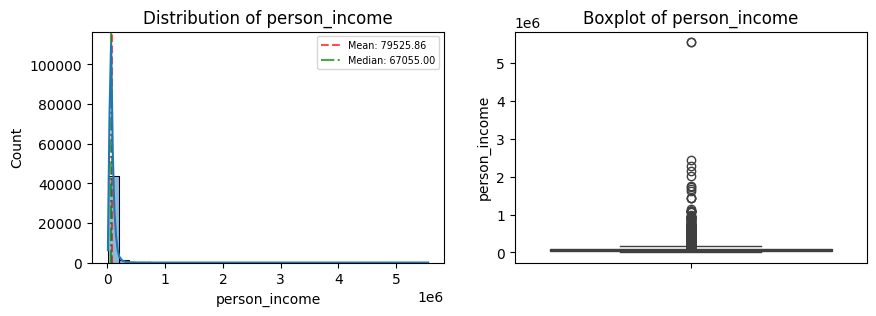

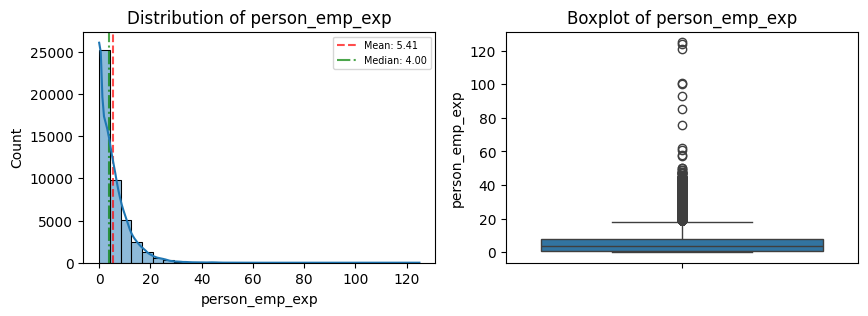

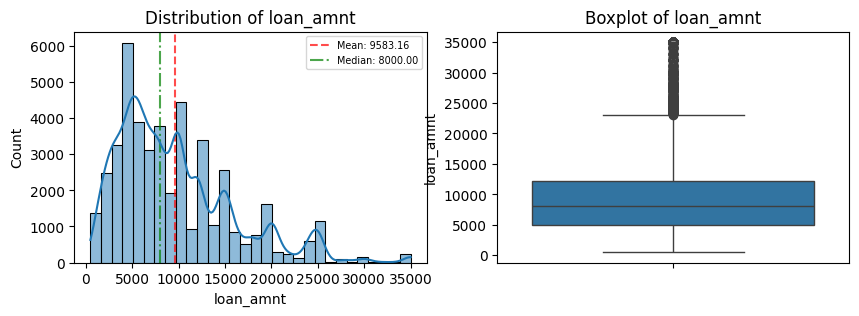

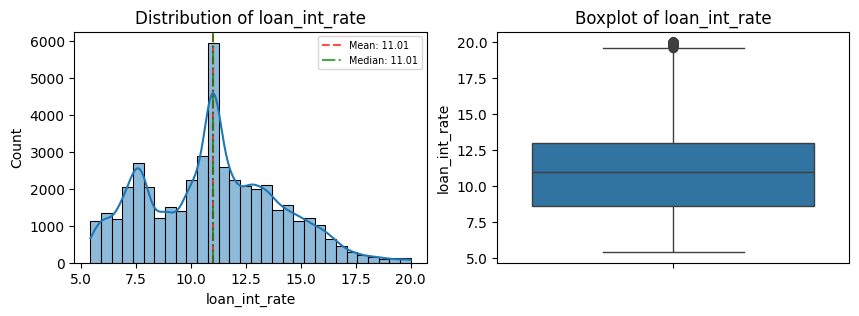

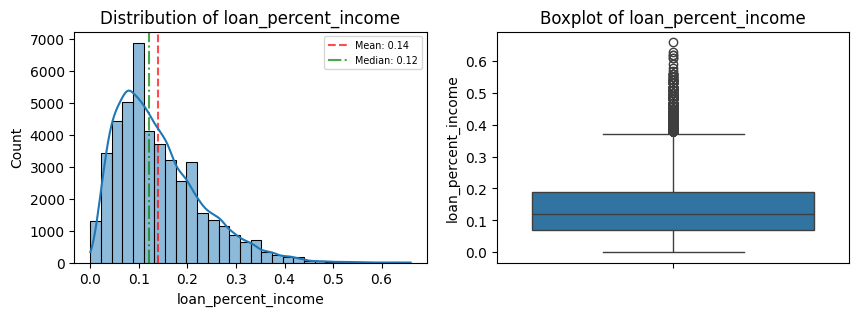

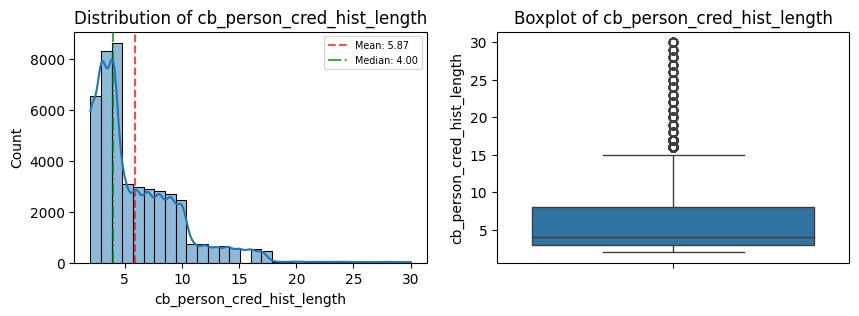

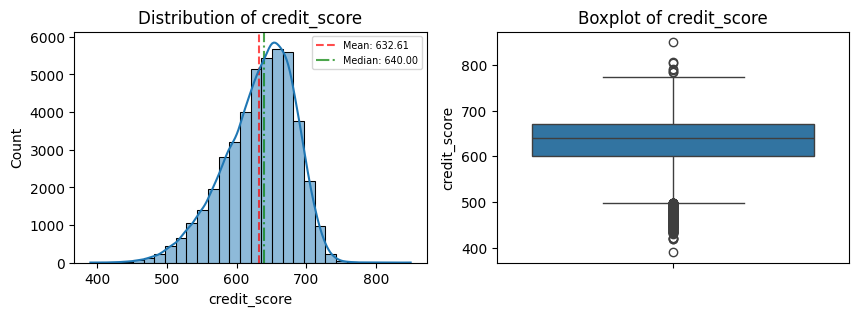

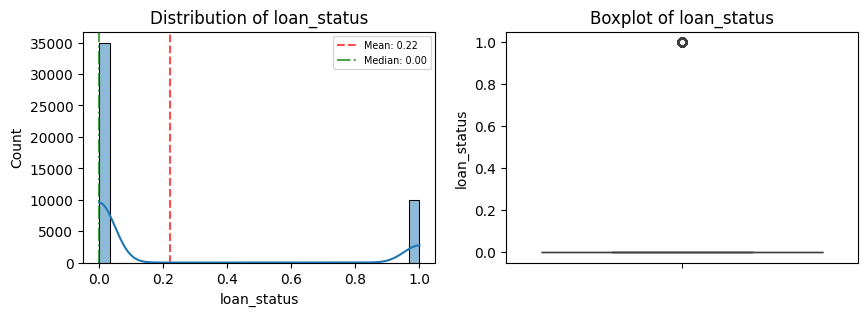

In [9]:
# Plotting the numerical columns
for col in numerical:
        plt.figure(figsize=(10, 3))

        # Plot Histogram
        mean = df[col].mean()
        median = df[col].median()
        skew = df[col].skew()
        kurt = df[col].kurt()
        plt.subplot(1, 2, 1)
        plt.axvline(mean, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean:.2f}')
        plt.axvline(median, color='green', linestyle='-.', alpha=0.7, label=f'Median: {median:.2f}')
        plt.legend(fontsize='x-small')
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'Distribution of {col}')

        # Plot Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')

        plt.show()

__EXPLANATION__ : All of the numerical columns are not normally distributed and there are a lot outliers

In [10]:
def handle_outliers(df, cols, target_variable, method='cap'):
    df_clean = df.copy()
    for col in cols:
        if col != target_variable:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            outliers = df_clean[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)]
            print(f"{col}: {len(outliers)} outliers")

            if method == 'remove':
                df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
            elif method == 'cap':
                df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
                df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
    
    return df_clean

__EXPLANATION__ : Make function to handle outliers and because we are using tree-based model, that is RandomForest and XGBoost, we use method='cap', where we keep all rows but push extreme values to the boundary of the IQR. We also skip our target_variable

In [11]:
df = handle_outliers(df, numerical, target_variable='loan_status')

person_age: 2188 outliers
person_income: 2378 outliers
person_emp_exp: 1724 outliers
loan_amnt: 2348 outliers
loan_int_rate: 124 outliers
loan_percent_income: 744 outliers
cb_person_cred_hist_length: 1366 outliers
credit_score: 467 outliers


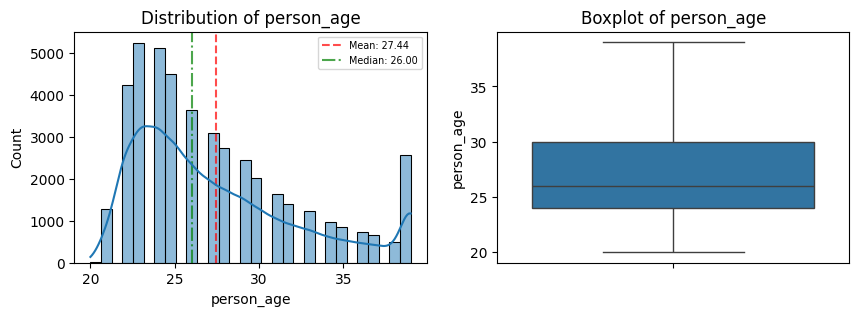

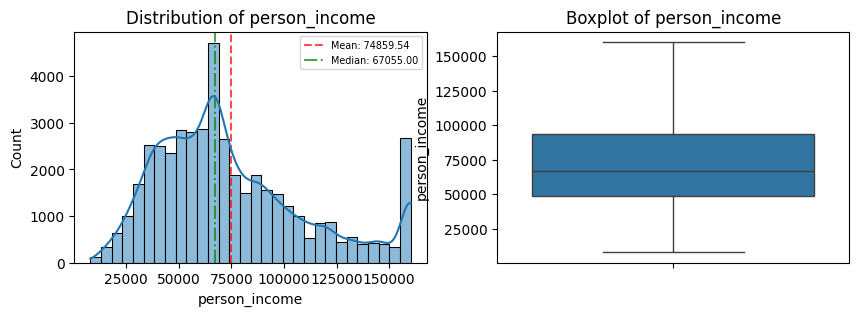

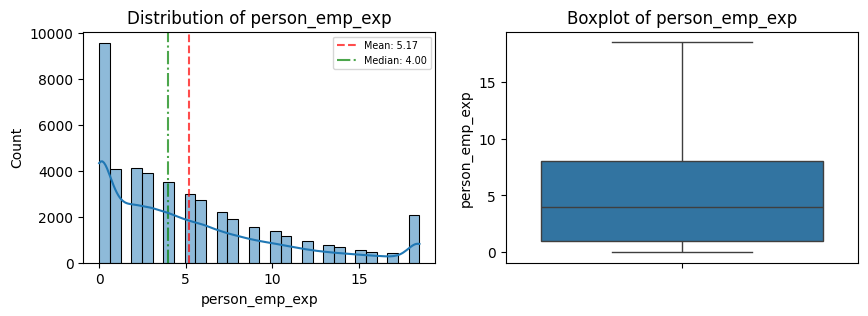

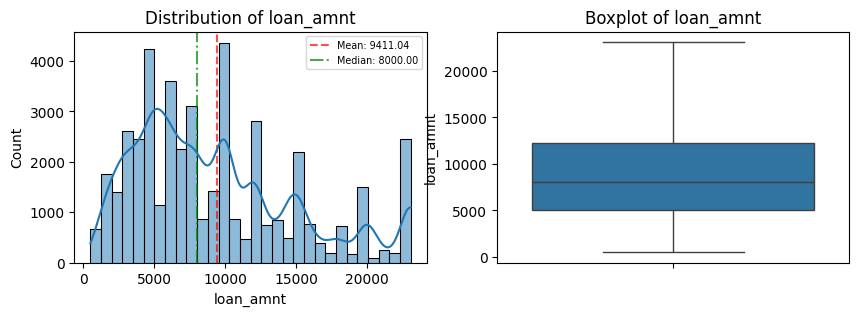

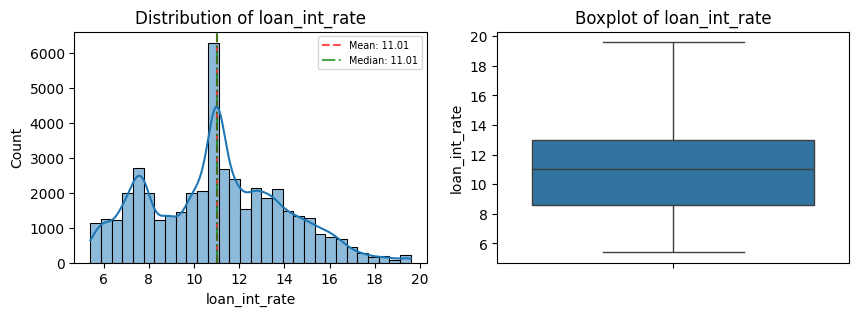

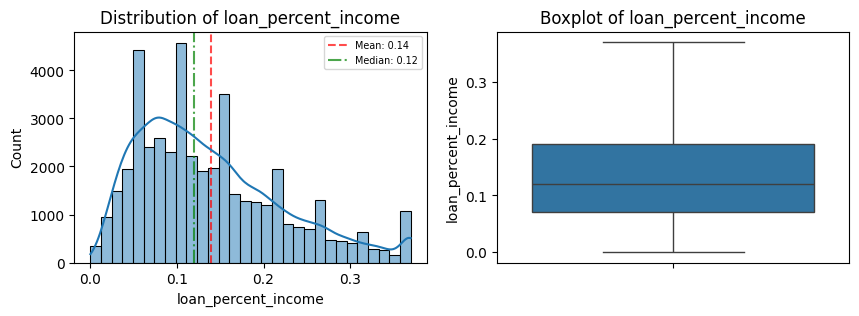

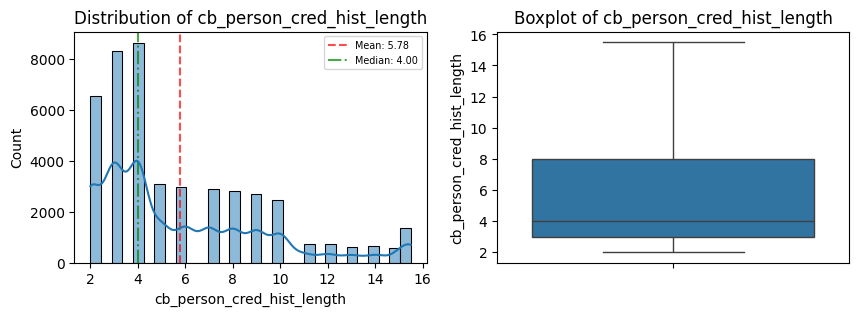

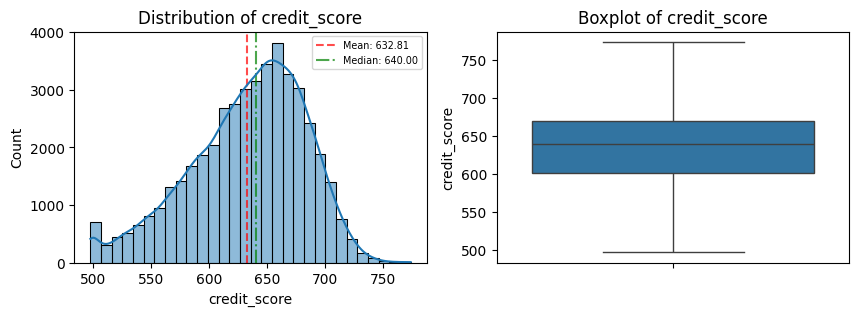

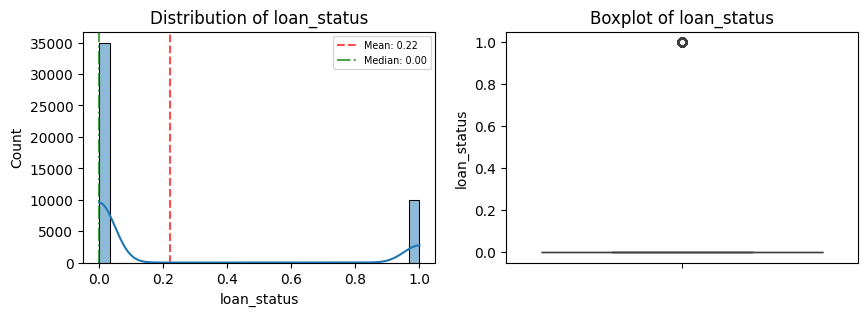

In [12]:
# Plotting the numerical columns
for col in numerical:
        plt.figure(figsize=(10, 3))

        # Plot Histogram
        mean = df[col].mean()
        median = df[col].median()
        skew = df[col].skew()
        kurt = df[col].kurt()
        plt.subplot(1, 2, 1)
        plt.axvline(mean, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean:.2f}')
        plt.axvline(median, color='green', linestyle='-.', alpha=0.7, label=f'Median: {median:.2f}')
        plt.legend(fontsize='x-small')
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'Distribution of {col}')

        # Plot Boxplot
        plt.subplot(1, 2, 2)
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')

        plt.show()

__EXPLANATION__ : We have dealt with the outlier (exempting our target variable, loan_status)

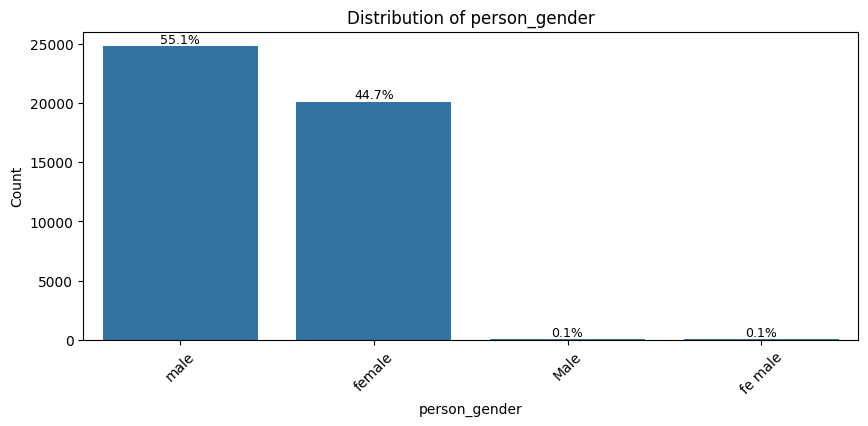

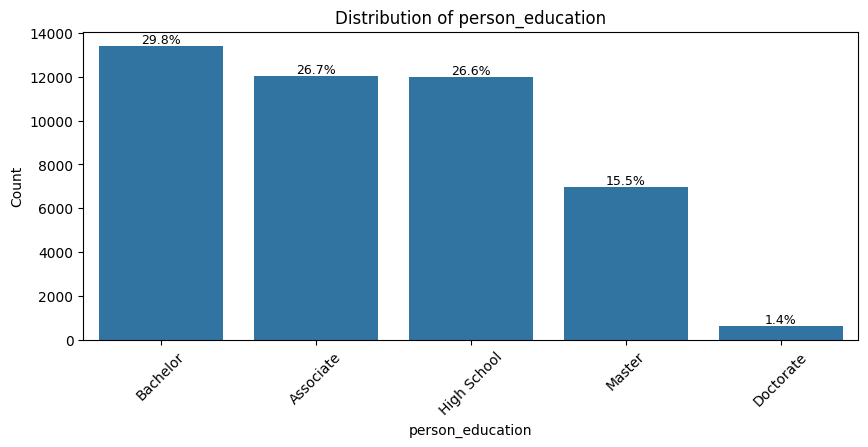

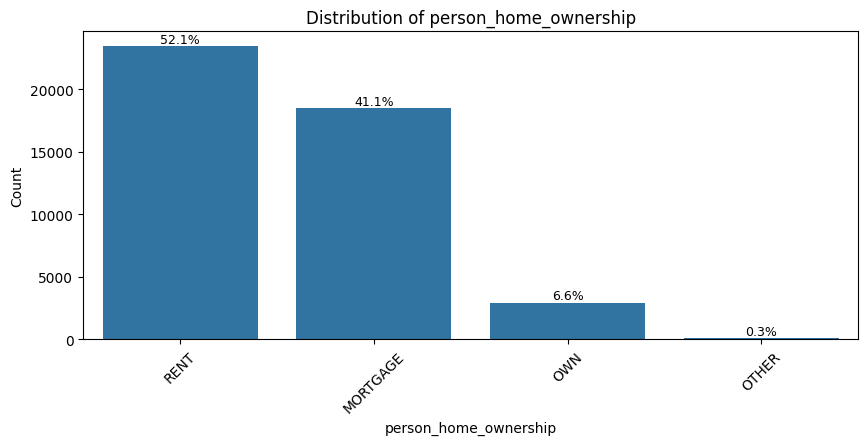

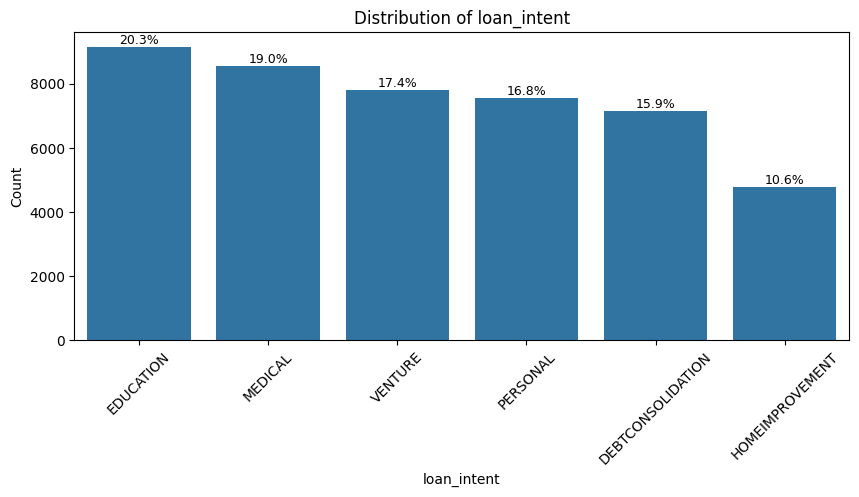

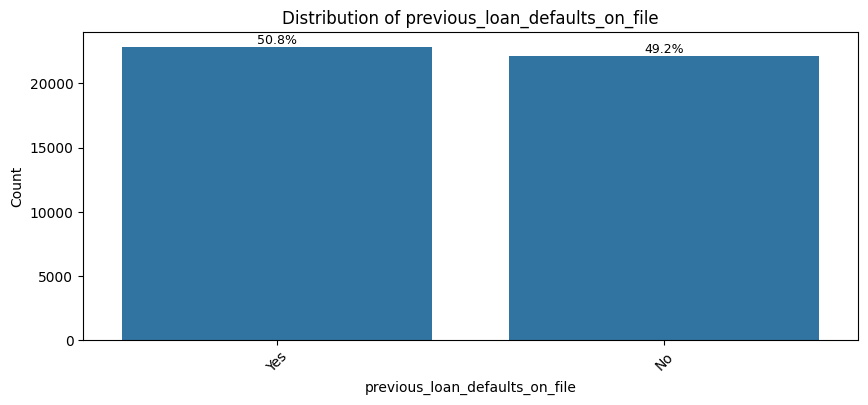

In [13]:
# Plotting the categorical columns
for cat_col in categorical:
    plt.figure(figsize=(10, 4))
    
    ax = sns.countplot(x=cat_col, data=df, order=df[cat_col].value_counts().index)
    
    total = len(df[cat_col])
    for p in ax.patches:
        height = p.get_height()
        percentage = f'{100 * height / total:.1f}%'
        ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)
    
    plt.title(f'Distribution of {cat_col}')
    plt.xticks(rotation=45)
    plt.xlabel(cat_col)
    plt.ylabel("Count")
    
    plt.show()


__EXPLANATION__ : From here, we can see that there are wrong format for male and female

In [14]:
df['person_gender'] = df['person_gender'].str.lower()

df['person_gender'] = df['person_gender'].replace({
    'fe male': 'female',
})

print(df['person_gender'].unique())

['female' 'male']


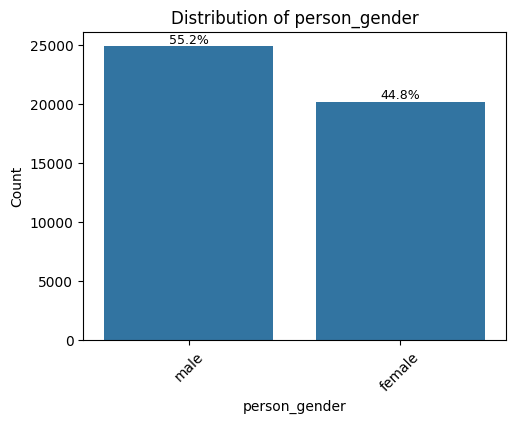

In [15]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
ax = sns.countplot(x='person_gender', data=df, order=df['person_gender'].value_counts().index)

total = len(df['person_gender'])
for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9)

plt.title(f'Distribution of {'person_gender'}')
plt.xticks(rotation=45)
plt.xlabel('person_gender')
plt.ylabel("Count")

plt.show()

__EXPLANATION__ : We've handled the anomaly in person_gender by making all the values lowercase and changing the wrong format to the correct format

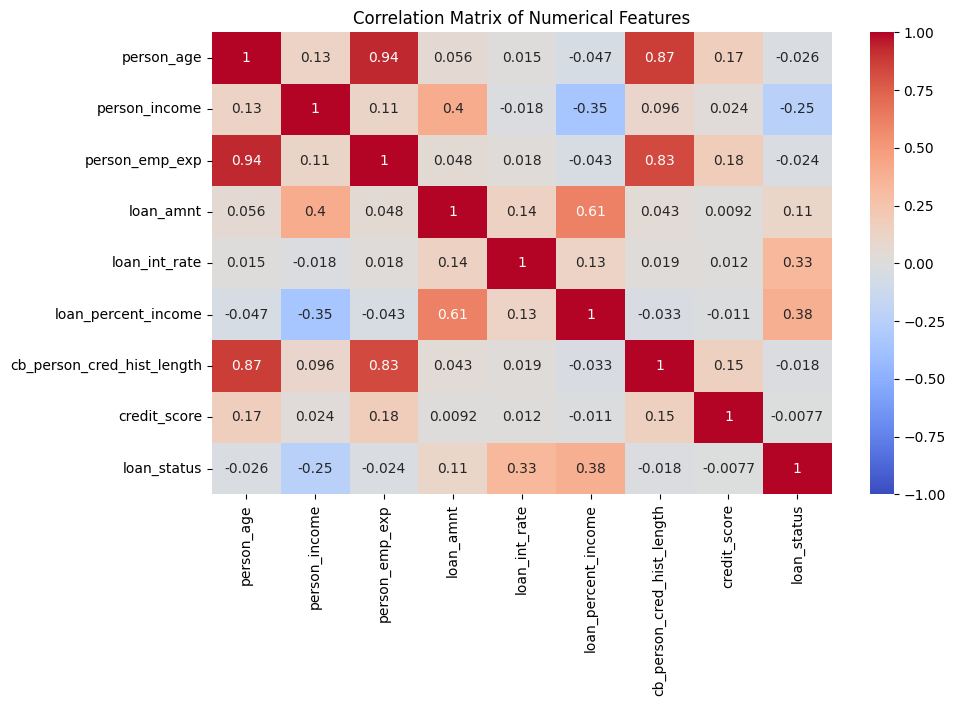

In [16]:
# bivariate analysis with correlation check
correlation_matrix = df[numerical].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

__EXPLANATION__ : We can see the strongest to weakest feature that affects loan_status with the top 3 loan_percent_income (0.38), loan_int_rate (0.33), and person_income (-0.25)

## Splitting Data

In [17]:
x = df[df.columns.drop('loan_status')]
y = df['loan_status']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

## Pre Processing

In [18]:
target_col = 'loan_status'

In [19]:
min_max_scaler = MinMaxScaler()

other_numerical = [col for col in numerical if col != target_col]

x_train[other_numerical] = min_max_scaler.fit_transform(x_train[other_numerical])
x_test[other_numerical] = min_max_scaler.transform(x_test[other_numerical])

__EXPLANATION__ : We only scale the numerical values and skip the loan_status, because it is binary we don't need to scale it

In [20]:
hierarchal_col = 'person_education'

hierarchal_cat = df[hierarchal_col]

non_hierarchal_cat = [col for col in categorical if col != hierarchal_col]

In [ ]:
# encode the non-hierarchal categorical with using OneHotEncoder
oh_encoder = OneHotEncoder(sparse_output=False)

x_train_oh = oh_encoder.fit_transform(x_train[non_hierarchal_cat])
x_test_oh = oh_encoder.transform(x_test[non_hierarchal_cat])

oh_columns = oh_encoder.get_feature_names_out(non_hierarchal_cat)

# Convert to DataFrame
x_train_oh_df = pd.DataFrame(x_train_oh, columns=oh_columns, index=x_train.index)
x_test_oh_df = pd.DataFrame(x_test_oh, columns=oh_columns, index=x_test.index)

# Drop original non-hierarchical categorical cols & concat encoded
x_train = pd.concat([x_train.drop(columns=non_hierarchal_cat), x_train_oh_df], axis=1)
x_test = pd.concat([x_test.drop(columns=non_hierarchal_cat), x_test_oh_df], axis=1)

In [22]:
# encode the categorical with hierarchy with using OrdinalEncoder
education_order = [["High School", "Associate", "Bachelor", "Master", "Doctorate"]]

od_encoder = OrdinalEncoder(categories=education_order)

x_train['person_education'] = od_encoder.fit_transform(x_train[['person_education']])
x_test['person_education'] = od_encoder.transform(x_test[['person_education']])

In [23]:
x_train.head()

,person_age,person_education,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,person_gender_female,...,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,previous_loan_defaults_on_file_No,previous_loan_defaults_on_file_Yes
37765,0.315789,2.0,0.380533,0.054054,0.036117,0.062103,0.054054,0.296296,0.451087,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
8523,0.263158,1.0,0.293536,0.270270,0.323107,0.121383,0.405405,0.074074,0.469203,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
19787,0.368421,2.0,0.464870,0.216216,0.132784,0.569513,0.108108,0.518519,0.639493,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
16707,0.263158,1.0,0.171926,0.108108,0.132784,0.393084,0.270270,0.148148,0.273551,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
40303,0.157895,0.0,0.216361,0.000000,0.420482,0.280169,0.648649,0.074074,0.288043,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [24]:
print(y_train.min(), y_train.max())

0 1


## Train & Evaluate Model

### Random Forest

In [25]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=123)
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=123)

In [26]:
rf_pred = rf_model.predict(x_test)

In [27]:
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)

print("Random Forest Metrics:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1 Score: {rf_f1:.4f}")
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, rf_pred))

Random Forest Metrics:
Accuracy: 0.9309
Precision: 0.9042
Recall: 0.7643
F1 Score: 0.8284

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      7036
           1       0.90      0.76      0.83      1964

    accuracy                           0.93      9000
   macro avg       0.92      0.87      0.89      9000
weighted avg       0.93      0.93      0.93      9000



### XGBoost

In [28]:
xgb_model = xgb.XGBClassifier(random_state=123)
xgb_model.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [29]:
xgb_pred = xgb_model.predict(x_test)

In [30]:
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_precision = precision_score(y_test, xgb_pred)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)

print("\nXGBoost Metrics:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1 Score: {xgb_f1:.4f}")
print("\nXGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))


XGBoost Metrics:
Accuracy: 0.9369
Precision: 0.8979
Recall: 0.8019
F1 Score: 0.8472

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7036
           1       0.90      0.80      0.85      1964

    accuracy                           0.94      9000
   macro avg       0.92      0.89      0.90      9000
weighted avg       0.94      0.94      0.94      9000



## Model Comparison

In [31]:
metrics_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [rf_accuracy, xgb_accuracy],
    'Precision': [rf_precision, xgb_precision],
    'Recall': [rf_recall, xgb_recall],
    'F1 Score': [rf_f1, xgb_f1]
})

print("\nModel Comparison:")
print(metrics_df)



Model Comparison:
           Model  Accuracy  Precision    Recall  F1 Score
0  Random Forest  0.930889   0.904217  0.764257  0.828366
1        XGBoost  0.936889   0.897948  0.801935  0.847230


## Selecting and Exporting Best Model

In [32]:
best_model = rf_model if rf_f1 > xgb_f1 else xgb_model
best_model_name = "Random Forest" if rf_f1 > xgb_f1 else "XGBoost"
print(f"\nBest model based on F1 score: {best_model_name}")


Best model based on F1 score: XGBoost


In [33]:
with open('best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

preprocessing_objects = {
    'min_max_scaler': min_max_scaler,
    'oh_encoder': oh_encoder,
    'od_encoder': od_encoder,
    'numerical_cols': other_numerical,
    'categorical_cols': categorical,
    'non_hierarchal_cat': non_hierarchal_cat,
    'hierarchal_col': hierarchal_col
}

with open('preprocessing_objects.pkl', 'wb') as file:
    pickle.dump(preprocessing_objects, file)

print("Best model and preprocessing objects saved successfully!")

Best model and preprocessing objects saved successfully!
